In [12]:
from models.inference_pipeline import CCTAPipeline
from models.unet3D import UNet3D, dice_bce_loss
from models.net_utils import calculate_jaccard_score, calculate_dice_score
import torch
from models.net_utils import get_best_device
from server_specific.server_utils import get_patients
import numpy as np

In [2]:
device = get_best_device()

torch.set_default_device(device)
print(f"Using {device} device. Every tensor created will be by default on {device}")


model = UNet3D(in_channels=1, num_classes=1)
model.load_state_dict(torch.load("saved_models/ccta_pred_model_64.pth", weights_only=True))
model.to(device)
model.eval()

Using cuda device. Every tensor created will be by default on cuda


UNet3D(
  (down_convolution_1): DownSample(
    (conv): DoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1)

In [3]:
print("-----INFERENCE_______")

patients = get_patients()
patients = np.array(patients)

test_patients = patients[700:]

print("Test dataset:", test_patients.shape)

-----INFERENCE_______
amt of detected_files:  1800
amt of patients:  800
Test dataset: (100,)


In [4]:
ccta_pipeline = CCTAPipeline(model, block_size=64)

In [5]:
test_ccta_scan, test_ccta_mask = test_patients[0].get_image_mask_tuple()

print(type(test_ccta_scan))
prediction = ccta_pipeline(test_ccta_scan)

<class 'numpy.ndarray'>
processing patch 1 / 320
processing patch 2 / 320
processing patch 3 / 320
processing patch 4 / 320
processing patch 5 / 320
processing patch 6 / 320
processing patch 7 / 320
processing patch 8 / 320
processing patch 9 / 320
processing patch 10 / 320
processing patch 11 / 320
processing patch 12 / 320
processing patch 13 / 320
processing patch 14 / 320
processing patch 15 / 320
processing patch 16 / 320
processing patch 17 / 320
processing patch 18 / 320
processing patch 19 / 320
processing patch 20 / 320
processing patch 21 / 320
processing patch 22 / 320
processing patch 23 / 320
processing patch 24 / 320
processing patch 25 / 320
processing patch 26 / 320
processing patch 27 / 320
processing patch 28 / 320
processing patch 29 / 320
processing patch 30 / 320
processing patch 31 / 320
processing patch 32 / 320
processing patch 33 / 320
processing patch 34 / 320
processing patch 35 / 320
processing patch 36 / 320
processing patch 37 / 320
processing patch 38 / 3

In [6]:
print(prediction.shape)

(275, 512, 512)


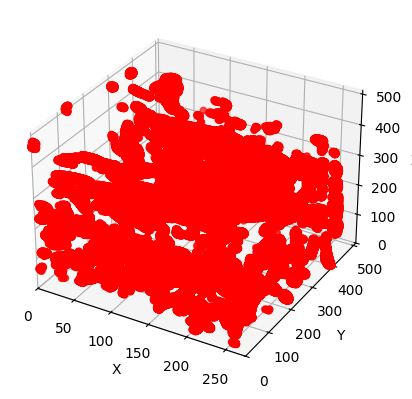

In [9]:
from data_generation.generate_3d import visualize3Dimage

visualize3Dimage(prediction)

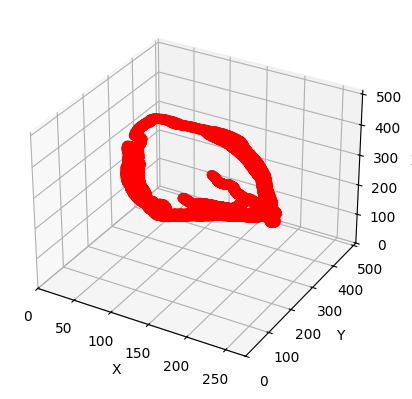

In [10]:
visualize3Dimage(test_ccta_mask)

In [17]:
# loss = dice_bce_loss(prediction, test_ccta_mask).item()
jaccard = calculate_jaccard_score(prediction, test_ccta_mask)
print(jaccard)

dice = calculate_dice_score(prediction, test_ccta_mask)
print(dice)

0.09003954680769567
0.165204183777344
